In [1]:
from fastai.vision import *

from adapter import loss_func, get_y_func, load_voc, has_person, json_to_paths, create_split_func, YoloCategoryList, \
    ApAt50
from models import Darknet
from train import hyp
from utils import torch_utils

In [2]:
images = load_voc()

In [3]:
# Build lists of positive and negative samples
positive_samp = [img for img in images.values() if has_person(img)]
negative_samp = [img for img in images.values() if not has_person(img)]
f"{len(positive_samp)}; {len(negative_samp)}"


'8566; 12937'

In [4]:
# Truncate negative samples to be roughly same length as positive
negative_samp = negative_samp[:len(positive_samp)]
len(negative_samp)

8566

In [6]:

# Combine sample sets back together
samples = positive_samp  # + negative_samp

In [7]:

# Load the model
img_size = (352, 608)
device = 'cuda:0'
arc = 'default'
cfg = 'cfg/yolov3-tiny-anchors.cfg'
weights = 'weights/40ap.pt'
device = torch_utils.select_device(device, apex=False, batch_size=64)
model = Darknet(cfg, img_size=img_size, arc=arc).to(device)
model.arc = 'default'
model.nc = 1  # num classes
model.hyp = hyp
d = torch.load(weights, map_location=device)
m = d['model']
model.load_state_dict(m)

# Build the paths and pass them to the FastAI ObjectItemList
posix_paths = json_to_paths(samples)
lst = ObjectItemList(posix_paths, label_cls=YoloCategoryList)
YoloCategoryList.anchors = [model.module_list[l].anchors for l in model.yolo_layers]
YoloCategoryList.img_size = img_size

Using CUDA device0 _CudaDeviceProperties(name='GeForce RTX 2070 with Max-Q Design', total_memory=7982MB)



In [8]:
# Turn all this into a FastAI DataBunch so we can train
data = (lst
        .split_by_valid_func(create_split_func(samples))
        .label_from_func(partial(get_y_func, images))
        .transform(
    get_transforms(),
    tfm_y=True,
    size=img_size,
    resize_method=ResizeMethod.PAD,
    padding_mode='zeros'
)
        .databunch(bs=16, collate_fn=bb_pad_collate))

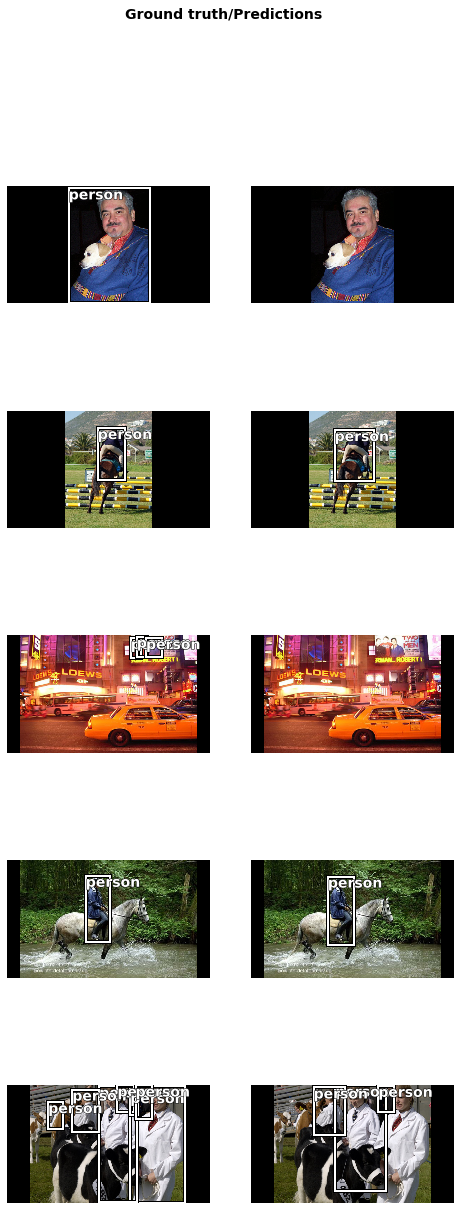

In [9]:
# Finally we have everything we need to make a learner
metrics = [ApAt50()]
learner = Learner(data, model, loss_func=partial(loss_func, model), metrics=metrics)
learner.show_results(rows=5)

In [10]:
epochs = 1
callbacks = []
cb_handler = CallbackHandler(callbacks, metrics)
pbar = master_bar(range(epochs))
cb_handler.on_train_begin(epochs, pbar=pbar, metrics=metrics)
val_loss = validate(learner.model, learner.data.valid_dl, loss_func=learner.loss_func,
                    cb_handler=cb_handler)

In [ ]:
val_loss